In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit,train_test_split

from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, Flatten, Activation, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Model,Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Using TensorFlow backend.


In [2]:
x = pd.read_csv("../input/train.csv")
y = x["label"]
x.drop("label",axis=1,inplace=True)
test = pd.read_csv("../input/test.csv")

In [3]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
test = scaler.transform(test)

In [4]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.4, stratify=y, random_state=45)

In [5]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
test = test.reshape(-1,28,28,1)

In [6]:
def cnn():
    np.random.seed(0)
    inp = Input( shape=(28,28, 1) )
    
    conv1 = Conv2D( filters=32, kernel_size=(3,3), strides=(1,1), padding='same' ) (inp)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = MaxPooling2D()(conv1)
    
    conv2 = Conv2D( filters=64, kernel_size=(3,3), strides=(1,1), padding='same' ) (conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = MaxPooling2D()(conv2)
    
    conv3 = Conv2D( filters=128, kernel_size=(2,2), strides=(1,1), padding='same' ) (conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = MaxPooling2D()(conv3)
    
    conv4 = Conv2D( filters=256, kernel_size=(2,2), strides=(1,1), padding='same' ) (conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = MaxPooling2D()(conv4)

    
    fc = Flatten()(conv4)
    
    fc = Dense(128,activation="relu")(fc)
    fc = Dropout(.2)(fc)
    
    fc = Dense(64,activation="relu")(fc)
    fc = Dropout(.2)(fc)
    
    fc = Dense(10)(fc)
    outp = Activation('softmax')(fc)
    
    model = Model(inp, outp)
    
    return model

In [7]:
cnn().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
__________

In [8]:
im_generator = ImageDataGenerator(data_format="channels_last",dtype=np.ndarray)
im_generator.fit(x_train)

In [9]:
optimizers_list = [('adam', Adam()),
                   ('sgd_momentum',SGD(momentum=.9) ),
                   ('adagrad',Adagrad()),
                   ('RMSprop',RMSprop()),
                   ('adadelta',Adadelta()),
                   ('sgd',SGD( lr=.1) )
                  ]
hists = []
for optimizer in optimizers_list:
    model = cnn()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer[1], metrics=['acc'])
    hist = model.fit_generator(generator=im_generator.flow(x_train, to_categorical(y_train), batch_size=2000),
                           validation_data=(x_test,to_categorical(y_test)),
                           epochs=100,
                           steps_per_epoch=5,
                           verbose=0,
                           validation_steps=1,
                           use_multiprocessing=True,
                           callbacks=[EarlyStopping(patience=10),ReduceLROnPlateau(patience=5,min_delta=0.1,min_lr=1e-4,cooldown=5)])
    hists.append(hist)

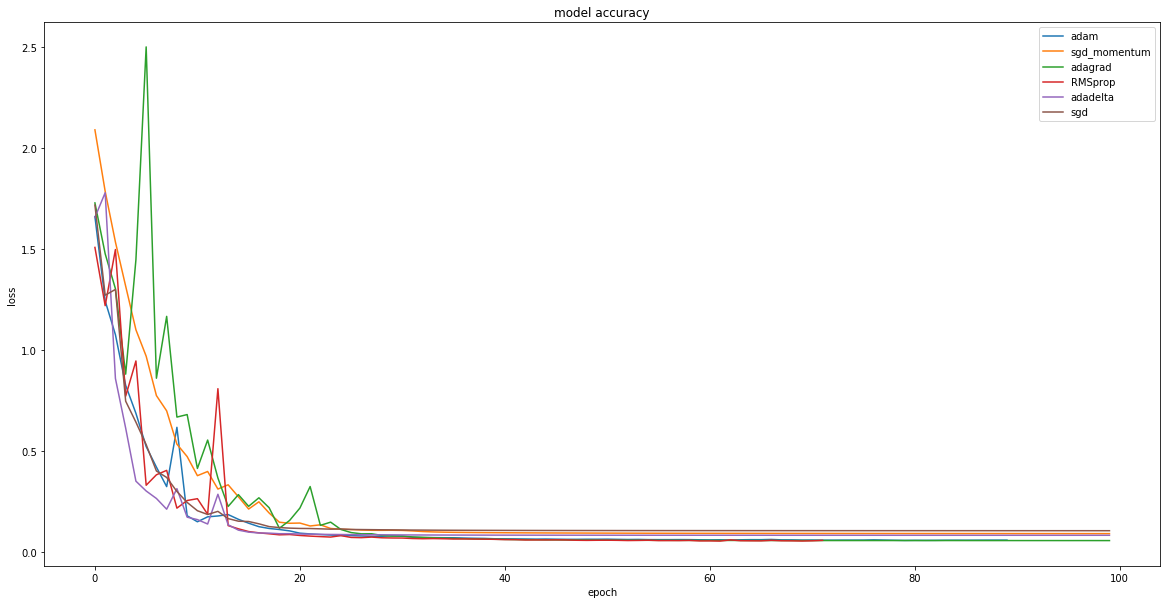

In [10]:
plt.figure(figsize=(20,10))

for hist in hists:
    plt.plot(hist.history["val_loss"])

plt.legend([optimizer[0] for optimizer in optimizers_list], loc='upper right')
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()